In [4]:
#Load the libraries to be used in the project
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',index_col=0, parse_dates=True).dropna()

In [6]:
BBStrategy = ta.Strategy(
    name="bb_strategy",
    ta=[{
        "close": 'close', 
        "kind": "bbands", 
        "length": 15,
        "std": 2
    }]
)

In [7]:
data = pd.DataFrame(raw['EUR='])
data.rename(columns={'EUR=': 'price'}, inplace=True)

In [8]:
data.ta.strategy(BBStrategy)

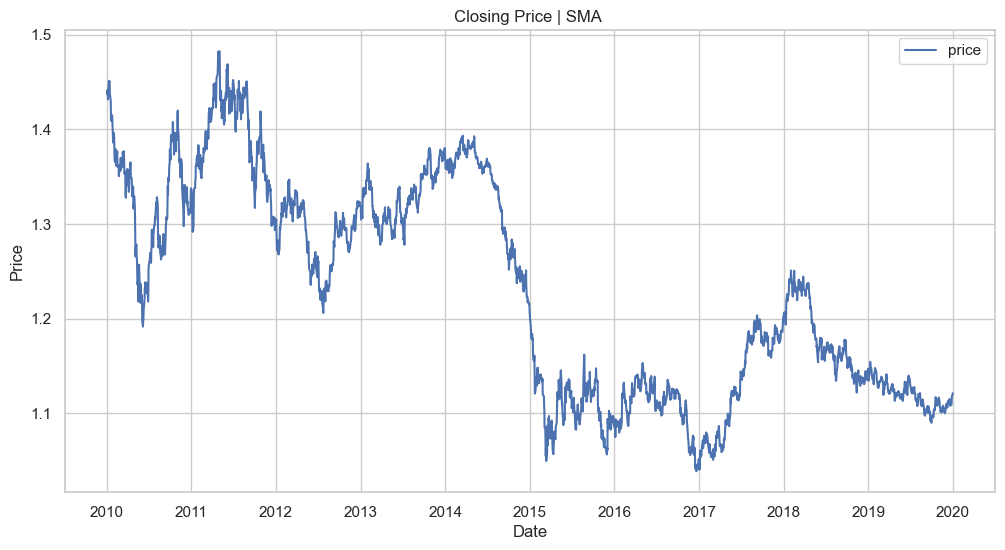

In [21]:
plt.figure(figsize = (12,6))
plot = sns.lineplot(data)
plot.set(xlabel = "Date" ,ylabel= "Price",title ="Closing Price | SMA " )
sns.set_style("whitegrid")
plt.show(plot)